**Self Attention, what it is ?**
- As the name states, attention which means empowering something to focus on important parts of the something. So in deep learning we focus more on input data. At first attention mechanism was introduced for RNN's for handling longer sequence to sequence information, but the problem arise with the text having a context, so for like ...if we do some kind of text translation, where the context of each word of occuring in a sentence. So that's why we needed context vector, which contains all the necessary information of the text. 

1. **Multiplicative Attention (Dot-Product Attention)** : so in here, we do the simple dot product of query and key vectors. The formula is given by :

    Attention(Q, K, V) = softmax(QK^T)V

    But the problem arises doing this, as the dimensions of the vector increases, the variance of dot product also increases. So when passed through the softmax function, can lead to higher probabilites being assigned to higher values and lower probabilities to lower values. To overcome this we do scaled dot product mechanism. 
2. **Scaled Dot-Product Attention** : So this is the popular self-attention mechanism. It Computes attention score taking dot product of query, key and value vector. And it scales the dot product by the square root of the dimension of the key vectors. 

Attention(Q,K,V)=softmax(QKT/√dk​)V

So the purpose of doing so is to stablizing the training process and prevent the dot product to become too large or too small.




In [1]:
# implemting self-attention in transformers

import torch
from torch import nn
import torch.nn.functional as F 
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name()}")


PyTorch version: 2.6.0+cu124
CUDA: True
Device name: NVIDIA A100-PCIE-40GB


In [2]:
## simple softmax function 
import numpy as np

def softmax_function(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

scores = [3.0, 1.0, 0.2] ## so that's why we do scaling to get the probability upto the sum of 1, and that's what softmax function do.
print(softmax_function(scores))

[0.8360188  0.11314284 0.05083836]


In [3]:
# Data
text_input = "I'm implementing self attention mechanism"
words = text_input.replace(',', '').split()
sorted_words = sorted(words, key=str.lower)  # sort ignoring case
unique_indexes = {s: i for i, s in enumerate(sorted_words)}
print(unique_indexes) # mapping each unqiue word in the sentence to its index in the alphabetically in a sorted list

{'attention': 0, "I'm": 1, 'implementing': 2, 'mechanism': 3, 'self': 4}


In [4]:
# map the sentence to a tensor of these integer indices
word_ids = [unique_indexes[word] for word in words]
sentence_tensor = torch.tensor(word_ids)

print("\nInput as tensor:")
print(sentence_tensor)



Input as tensor:
tensor([1, 2, 4, 0, 3])


In [5]:
# so the above was the normal input, now introducing positional encoding
import numpy as np 

class PositionalEncoding():
    """An implementation of sinusodial positional encoding, which basically utilised sine and cosine function"""
    
    def __init__(self,d_model, max_length, rounding):
        self.d_model = d_model # no. of dimensions in each word embeddings (e.g 768)
        self.max_length = max_length # no. of max tokens in a sequence (e.g 768)
        self.rounding = rounding # simple decimal rounding
    
    def positional_encoding(self):
        position = np.arange(0, self.max_length).reshape(self.max_length, 1) # each word postion in sentence
        even_indices = np.arange(0, self.d_model, 2)
        denominator = 10_000**(even_indices/self.d_model)

        #for even indices we use sin formula and for odd we use cosine
        even_encoding = np.sin(position/denominator)
        odd_encoding = np.cos(position/denominator)

        # merging both function together
        merging = np.stack((even_encoding, odd_encoding), axis=2) # Shape: (max_len, d_model//2, 2)
        positional_sincosine = merging.reshape(self.max_length, -1)

        if self.d_model%2 == 1: # if the model shape is something odd means not (768 or so)
            positional_sincosine = positional_sincosine[:,:-1]
        return np.round(positional_sincosine, self.rounding)

    def encoding(self, input_array):
        "Adding positional embeddings"
        pe = self.positional_encoding()
        return input_array + pe


In [6]:
embedding_dim = 6 
max_length = len(word_ids)
rounding = 4

embedding_matrix = np.random.rand(len(unique_indexes), embedding_dim)
embedding_sentence = np.array([embedding_matrix[word_id] for word_id in word_ids])
print(f"Embedded sentence shape: {embedding_sentence.shape}")
print(embedding_sentence)  # now this sentence is represented as 5x6 matrix, with each embedded into a 3-D vector

pe_encoder = PositionalEncoding(d_model=embedding_dim, max_length=max_length, rounding=rounding)
sentence_with_pe = pe_encoder.encoding(embedding_sentence)

Embedded sentence shape: (5, 6)
[[0.87530112 0.70440315 0.95551812 0.49109194 0.06750429 0.11418206]
 [0.03778112 0.56095649 0.59754639 0.83275274 0.30393995 0.19931633]
 [0.80239909 0.28010868 0.85085248 0.99893606 0.40609261 0.68367776]
 [0.4407853  0.04167069 0.47231574 0.60103209 0.86341887 0.78693199]
 [0.67423978 0.77656349 0.89839589 0.18184988 0.95579641 0.09005941]]


In [7]:
# outputs 

print("\n=== Original Embeddings ===")
print(np.round(embedding_sentence, rounding))

print("\n=== Positional Encoding Added the final input for the transformer encoder===")
print(np.round(sentence_with_pe, rounding))

print("\n=== Positional Encoding Matrix ===")
print(pe_encoder.positional_encoding())


=== Original Embeddings ===
[[0.8753 0.7044 0.9555 0.4911 0.0675 0.1142]
 [0.0378 0.561  0.5975 0.8328 0.3039 0.1993]
 [0.8024 0.2801 0.8509 0.9989 0.4061 0.6837]
 [0.4408 0.0417 0.4723 0.601  0.8634 0.7869]
 [0.6742 0.7766 0.8984 0.1818 0.9558 0.0901]]

=== Positional Encoding Added the final input for the transformer encoder===
[[ 0.8753  1.7044  0.9555  1.4911  0.0675  1.1142]
 [ 0.8793  1.1013  0.6439  1.8317  0.3061  1.1993]
 [ 1.7117 -0.136   0.9436  1.9946  0.4104  1.6837]
 [ 0.5819 -0.9483  0.6111  1.5913  0.8699  1.7869]
 [-0.0826  0.123   1.083   1.1646  0.9644  1.0901]]

=== Positional Encoding Matrix ===
[[ 0.      1.      0.      1.      0.      1.    ]
 [ 0.8415  0.5403  0.0464  0.9989  0.0022  1.    ]
 [ 0.9093 -0.4161  0.0927  0.9957  0.0043  1.    ]
 [ 0.1411 -0.99    0.1388  0.9903  0.0065  1.    ]
 [-0.7568 -0.6536  0.1846  0.9828  0.0086  1.    ]]


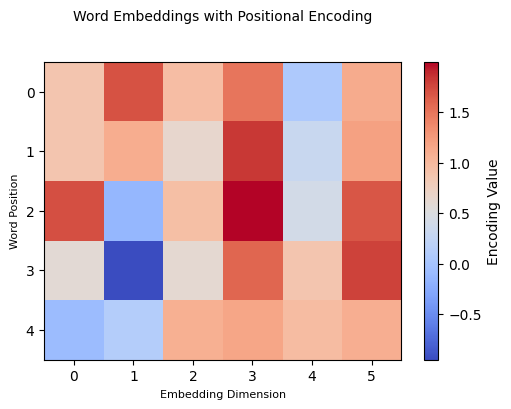

In [8]:
import matplotlib.pyplot as plt
import math
# Visualize embeddings with positional encoding
cax = plt.matshow(sentence_with_pe, cmap='coolwarm')

# Title and labels
plt.title(f'Word Embeddings with Positional Encoding',
          fontsize=10, pad=30)
plt.ylabel('Word Position', fontsize=8)
plt.xlabel('Embedding Dimension', fontsize=8)

# Move x-axis to bottom
plt.gca().xaxis.set_ticks_position('bottom')

# Add colorbar
plt.colorbar(cax, shrink=0.8, aspect=20, label='Encoding Value')

# Improve layout
# plt.tight_layout()

# Show plot
plt.show()

# hard to visulaise pattern, due to small embedding_dim and the length..but it works this way 

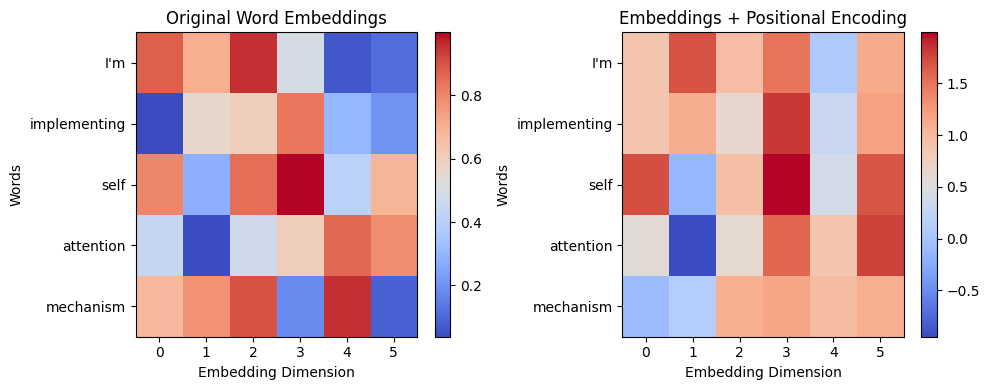

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Original embeddings
im1 = ax1.imshow(embedding_sentence, cmap='coolwarm', aspect='auto')
ax1.set_title('Original Word Embeddings')
ax1.set_ylabel('Words')
ax1.set_xlabel('Embedding Dimension')
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
plt.colorbar(im1, ax=ax1)

# With positional encoding
im2 = ax2.imshow(sentence_with_pe, cmap='coolwarm', aspect='auto')
ax2.set_title('Embeddings + Positional Encoding')
ax2.set_ylabel('Words')
ax2.set_xlabel('Embedding Dimension')
ax2.set_yticks(range(len(words)))
ax2.set_yticklabels(words)
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

In [10]:
class SelfAttention(nn.Module):
    def __init__(self,d_model, d_q, d_k, d_v):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.d_q = d_q
        self.d_k = d_k
        self.d_v = d_v
        self.w_query = nn.Parameter(torch.rand(d_model, d_q))
        self.w_key = nn.Parameter(torch.rand(d_model, d_k))
        self.w_value = nn.Parameter(torch.rand(d_model, d_v))

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
            
        Q = x @ self.w_query
        K = x @ self.w_key
        V = x @ self.w_value
        attention_score = Q @ K.T/math.sqrt(self.d_k)
        attention_weights = F.softmax(attention_score, dim =-1)
        context_vector = attention_weights @ V
        return context_vector

In [11]:
selfatt = SelfAttention(d_model=6,d_q=3,d_k=3,d_v=3)
context = selfatt(embedding_sentence)
print(context.shape)
print(context)

torch.Size([5, 3])
tensor([[1.9710, 1.0905, 1.6680],
        [1.9767, 1.1012, 1.6838],
        [1.9914, 1.1088, 1.6859],
        [1.9852, 1.1031, 1.6892],
        [1.9709, 1.0930, 1.6673]], grad_fn=<MmBackward0>)
